In [29]:
import numpyro
import numpy as np
import pandas as pd
import jax.numpy as jnp

from rt_from_frequency_dynamics import discretise_gamma, discretise_lognorm, pad_delays
from rt_from_frequency_dynamics import get_standard_delays
from rt_from_frequency_dynamics import FreeGrowthModel, FixedGrowthModel

from rt_from_frequency_dynamics import get_location_LineageData
from rt_from_frequency_dynamics import fit_SVI_locations, MultiPosterior
from rt_from_frequency_dynamics import unpack_model
from rt_from_frequency_dynamics import make_path_if_absent, make_model_directories
from rt_from_frequency_dynamics import gather_free_Rt, gather_fixed_Rt

In [2]:
data_name = "omicron-countries"
raw_cases = pd.read_csv(f"../data/{data_name}_location-case-counts.tsv", sep="\t")
raw_seq = pd.read_csv(f"../data/{data_name}_location-variant-sequence-counts.tsv", sep="\t")

In [3]:
# Locations to run
locations = pd.unique(raw_seq["location"])

In [4]:
# Defining Lineage Models
seed_L = 14
forecast_L = 0

# Get delays
gen = discretise_gamma(mn=5.2, std=1.72)
delays = [discretise_lognorm(mn=6.9, std=2.0)]
delays = pad_delays(delays)
    
LM_free = FreeGrowthModel(gen, delays, seed_L, forecast_L)
LM_fixed = FixedGrowthModel(gen, delays, seed_L, forecast_L)

In [5]:
# Params for fitting
opt = numpyro.optim.Adam(step_size=1e-2)
iters = 100_000
num_samples = 3000
save = True
load = False

In [6]:
# Paths for export
path_base = f"../estimates/{data_name}"
path_free = path_base + "/free"
path_fixed = path_base + "/fixed"

make_model_directories(path_free)
make_model_directories(path_fixed)

# Running models and exporting results

In [7]:
# Running free model
MP_free = fit_SVI_locations(raw_cases, raw_seq, locations, 
                            LM_free, opt, 
                            iters=iters, num_samples=num_samples, save=save, load=load, path=path_free)   

Location South Africa finished (1/2).
Location United Kingdom finished (2/2).


In [8]:
# Running fixed model
MP_fixed = fit_SVI_locations(raw_cases, raw_seq, locations, 
                             LM_fixed, opt, 
                             iters=iters, num_samples=num_samples, save=save, load=load, path=path_fixed)

Location South Africa finished (1/2).
Location United Kingdom finished (2/2).


In [9]:
# Exporting growth info
ps = [0.95, 0.8, 0.5] # Which credible intevals to save
R_free = gather_free_Rt(MP_free, ps, path=path_base, name=data_name)
R_fixed, ga_fixed = gather_fixed_Rt(MP_fixed, ps, path=path_base, name=data_name)

# Making figures

In [10]:
# Figures for export
path_fig = path_base + "/figures"
make_path_if_absent(path_fig)

In [11]:
from rt_from_frequency_dynamics.plotfunctions import *
ps = DefaultAes.ps
alphas = DefaultAes.alphas
v_colors = ["#56e39f", "#9932CC", "#808080"]
v_names = ['Delta', 'Omicron', 'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [12]:
import matplotlib
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [13]:
# What to output?

In [54]:
# Variant frequencies for each location from free R model
def posterior_frequencies_by_country(MP, ps, alphas, color_map):
    locations = list(MP.locator.keys())
    n_locations = len(locations)

    fig = plt.figure(figsize=(30, 10))
    gs = fig.add_gridspec(nrows=1, ncols=n_locations)
    
    ax_list = []
    for i, loc in enumerate(locations):
        ax = fig.add_subplot(gs[0,i])
        dataset, LD = unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        plot_posterior_frequency(ax, dataset, ps, alphas, colors)
        plot_observed_frequency(ax, LD, colors)
        add_dates(ax, LD.dates, sep=2)
        
     
    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.2)
    return fig

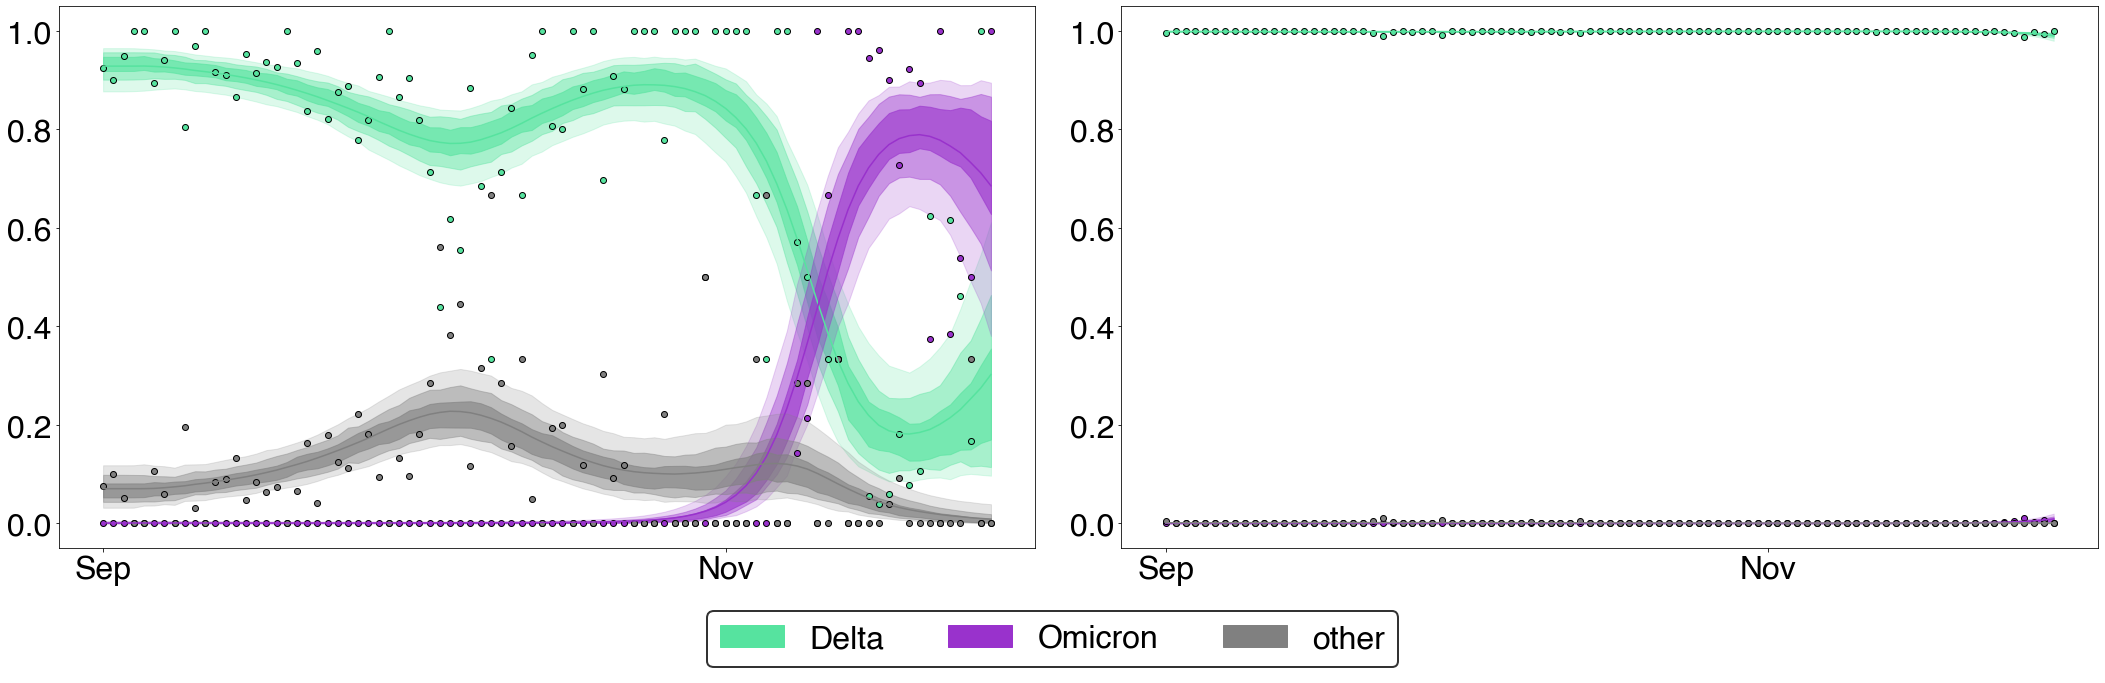

In [55]:
fig_freq = posterior_frequencies_by_country(MP_free, ps, alphas, color_map)

In [78]:
# Case counts partitioned by variant
# Effective reproductive number estimates by country
def posterior_cases_R_by_country(MP, ps, alphas, color_map):
    locations = list(MP.locator.keys())
    n_locations = len(locations)

    fig = plt.figure(figsize=(30, 15))
    gs = fig.add_gridspec(nrows=2, ncols=n_locations,  height_ratios=[2.,2.])

    ax_list_cases = []
    ax_list_R = []
    for i, loc in enumerate(locations):
        # Create axes
        if i == 0:
            ax_cases = fig.add_subplot(gs[0,i])
            ax_R = fig.add_subplot(gs[1,i])
        else:
            ax_cases = fig.add_subplot(gs[0,i])
            ax_R = fig.add_subplot(gs[1,i], sharey = ax_list_R[0])
            
        dataset, LD = unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        # Plot cases and posterior lineage I
        plot_cases(ax_cases, LD)
        plot_posterior_I(ax_cases, dataset, ps, alphas, colors)
        add_dates(ax_cases, LD.dates)

        # Plot posterior R valuse
        plot_R_censored(ax_R, dataset, ps, alphas, colors, thres=0.001)
        add_dates(ax_R, LD.dates)
        
        
        if i == 0:
            ax_cases.set_ylabel("Posterior variant cases")
            ax_R.set_ylabel("Posterior variant Rt")
            
        ax_list_cases.append(ax_cases)
        ax_list_R.append(ax_R)
        
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.2) 
    return fig

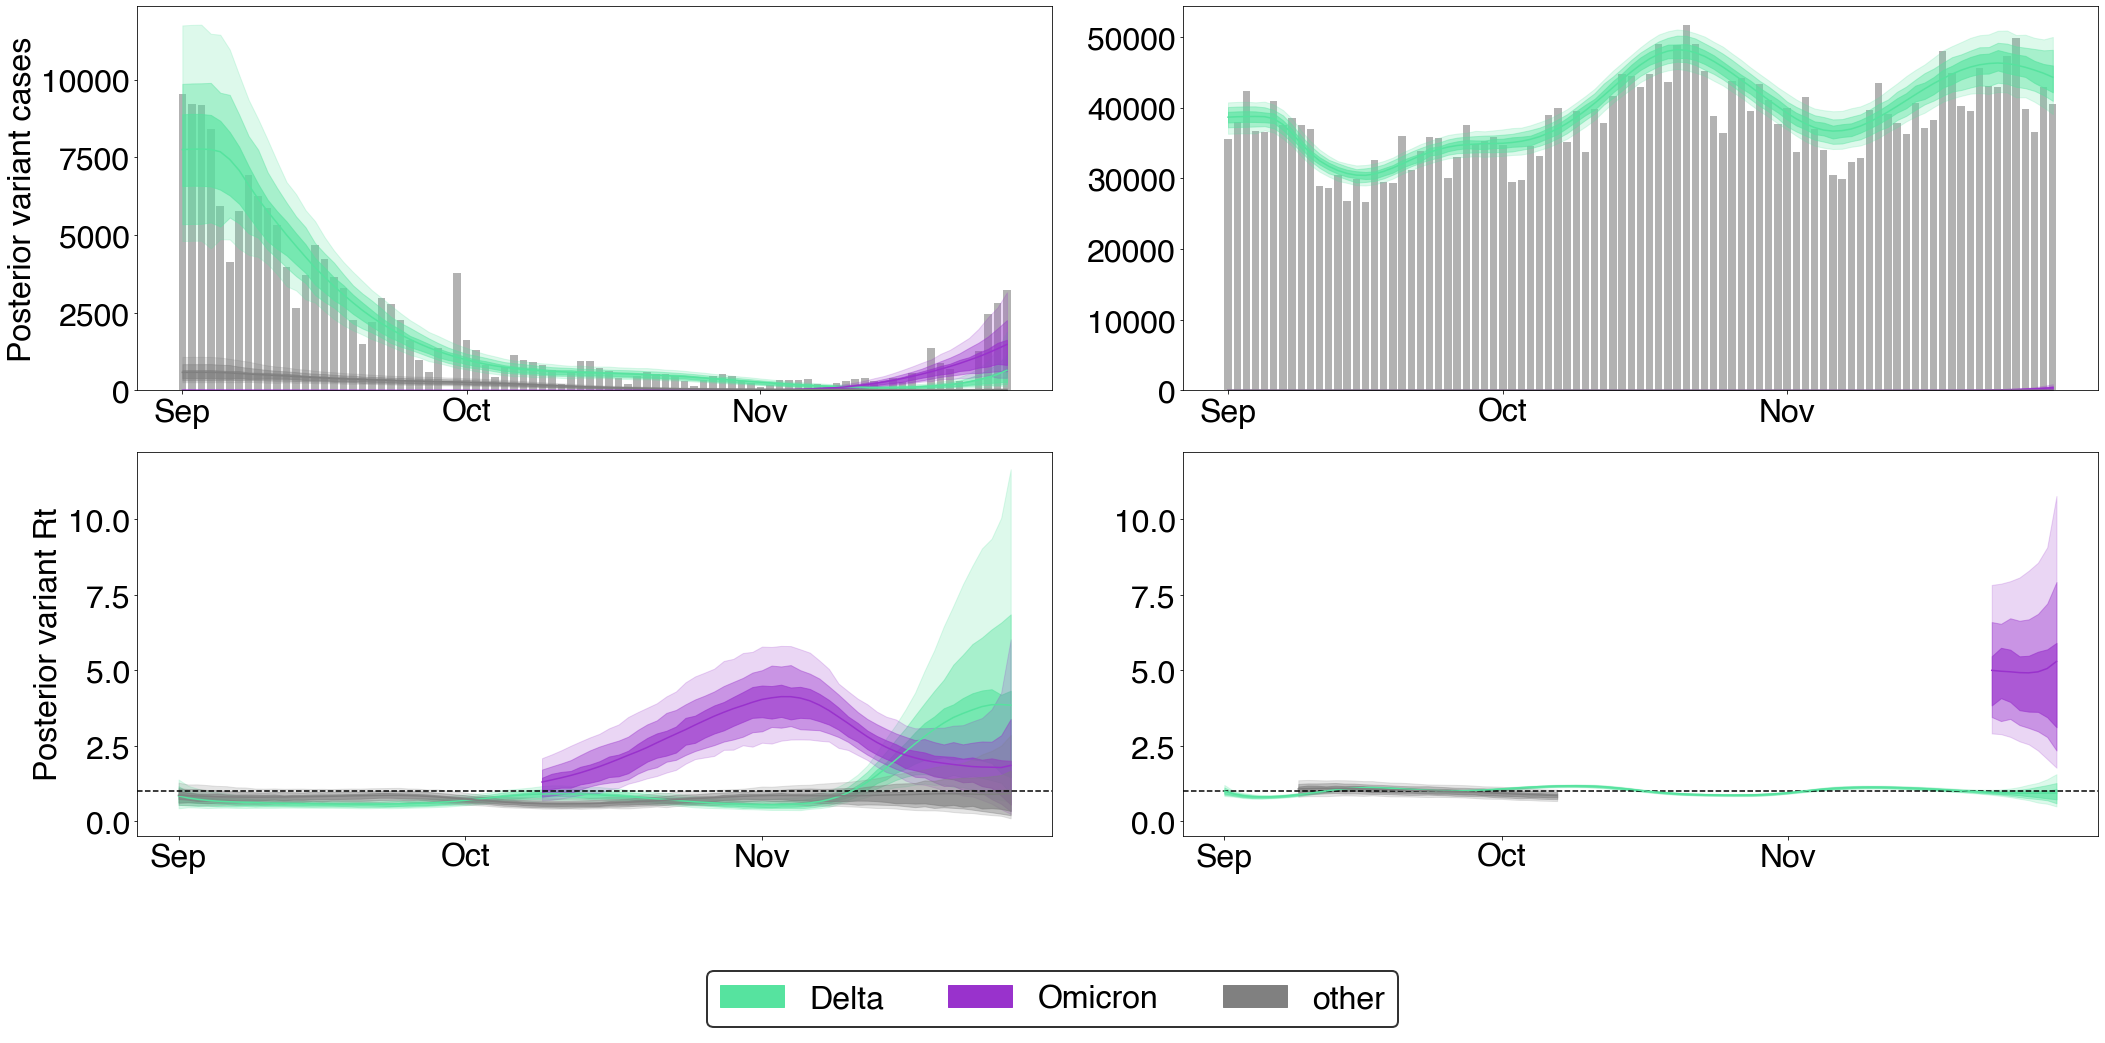

In [79]:
fig_case_R = posterior_cases_R_by_country(MP_free, ps, alphas, color_map);

# Growth rates by variant by country

In [80]:
def plot_little_r_censored(ax, dataset, g, ps, alphas, colors, thres=0.001):
    med, R =  get_quants(dataset, ps, "R")
    t = jnp.arange(0, R[-1].shape[0], 1)
    N_lineage = R[-1].shape[1]
    med_freq = get_median(dataset, "freq")
    
    # Get generation time
    mn = np.sum([p * (x+1) for x, p in enumerate(g)]) # Get mean of discretized generation time
    sd = np.sqrt(np.sum([p * (x+1) **2 for x, p in enumerate(g)])-mn**2) # Get sd of discretized generation time
    e_ = sd**2 / mn**2
    l = mn / (sd**2)
    
    def _to_little_r(R):
        return (jnp.float_power(R, e_) - 1) * l
        
    # Make figure
    ax.axhline(y=0.0, color='k', linestyle='--')
    for lineage in range(N_lineage):
        include = med_freq[:, lineage] > thres
        for i in range(len(ps)):
            ax.fill_between(t[include], 
                            _to_little_r(R[i][include, lineage, 0]), 
                            _to_little_r(R[i][include, lineage, 1]),
                            color=colors[lineage], alpha=alphas[i])
        ax.plot(t[include], _to_little_r(med[include, lineage]),
                color=colors[lineage])     

In [82]:
def posterior_cases_epidemic_gr_by_country(MP, g, ps, alphas, color_map):
    locations = list(MP.locator.keys())
    n_locations = len(locations)

    fig = plt.figure(figsize=(30, 15))
    gs = fig.add_gridspec(nrows=2, ncols=n_locations,  height_ratios=[2.,1.5])

    ax_list_cases = []
    ax_list_r = []
    for i, loc in enumerate(locations):
        # Create axes
        if i == 0:
            ax_cases = fig.add_subplot(gs[0,i])
            ax_r = fig.add_subplot(gs[1,i])
        else:
            ax_cases = fig.add_subplot(gs[0,i])
            ax_r = fig.add_subplot(gs[1,i], sharey = ax_list_r[0])
            
        dataset, LD = unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        # Plot cases and posterior lineage I
        plot_cases(ax_cases, LD)
        plot_posterior_I(ax_cases, dataset, ps, alphas, colors)
        add_dates(ax_cases, LD.dates)

        # Plot posterior little r values
        plot_little_r_censored(ax_r, dataset, g, ps, alphas, colors, thres=0.001)
        add_dates(ax_r, LD.dates)
        
        
        if i == 0:
            ax_cases.set_ylabel("Variant cases")
            ax_r.set_ylabel("Epidemic growth rate")
            
        ax_list_cases.append(ax_cases)
        ax_list_r.append(ax_r)

    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.2) 
    return fig

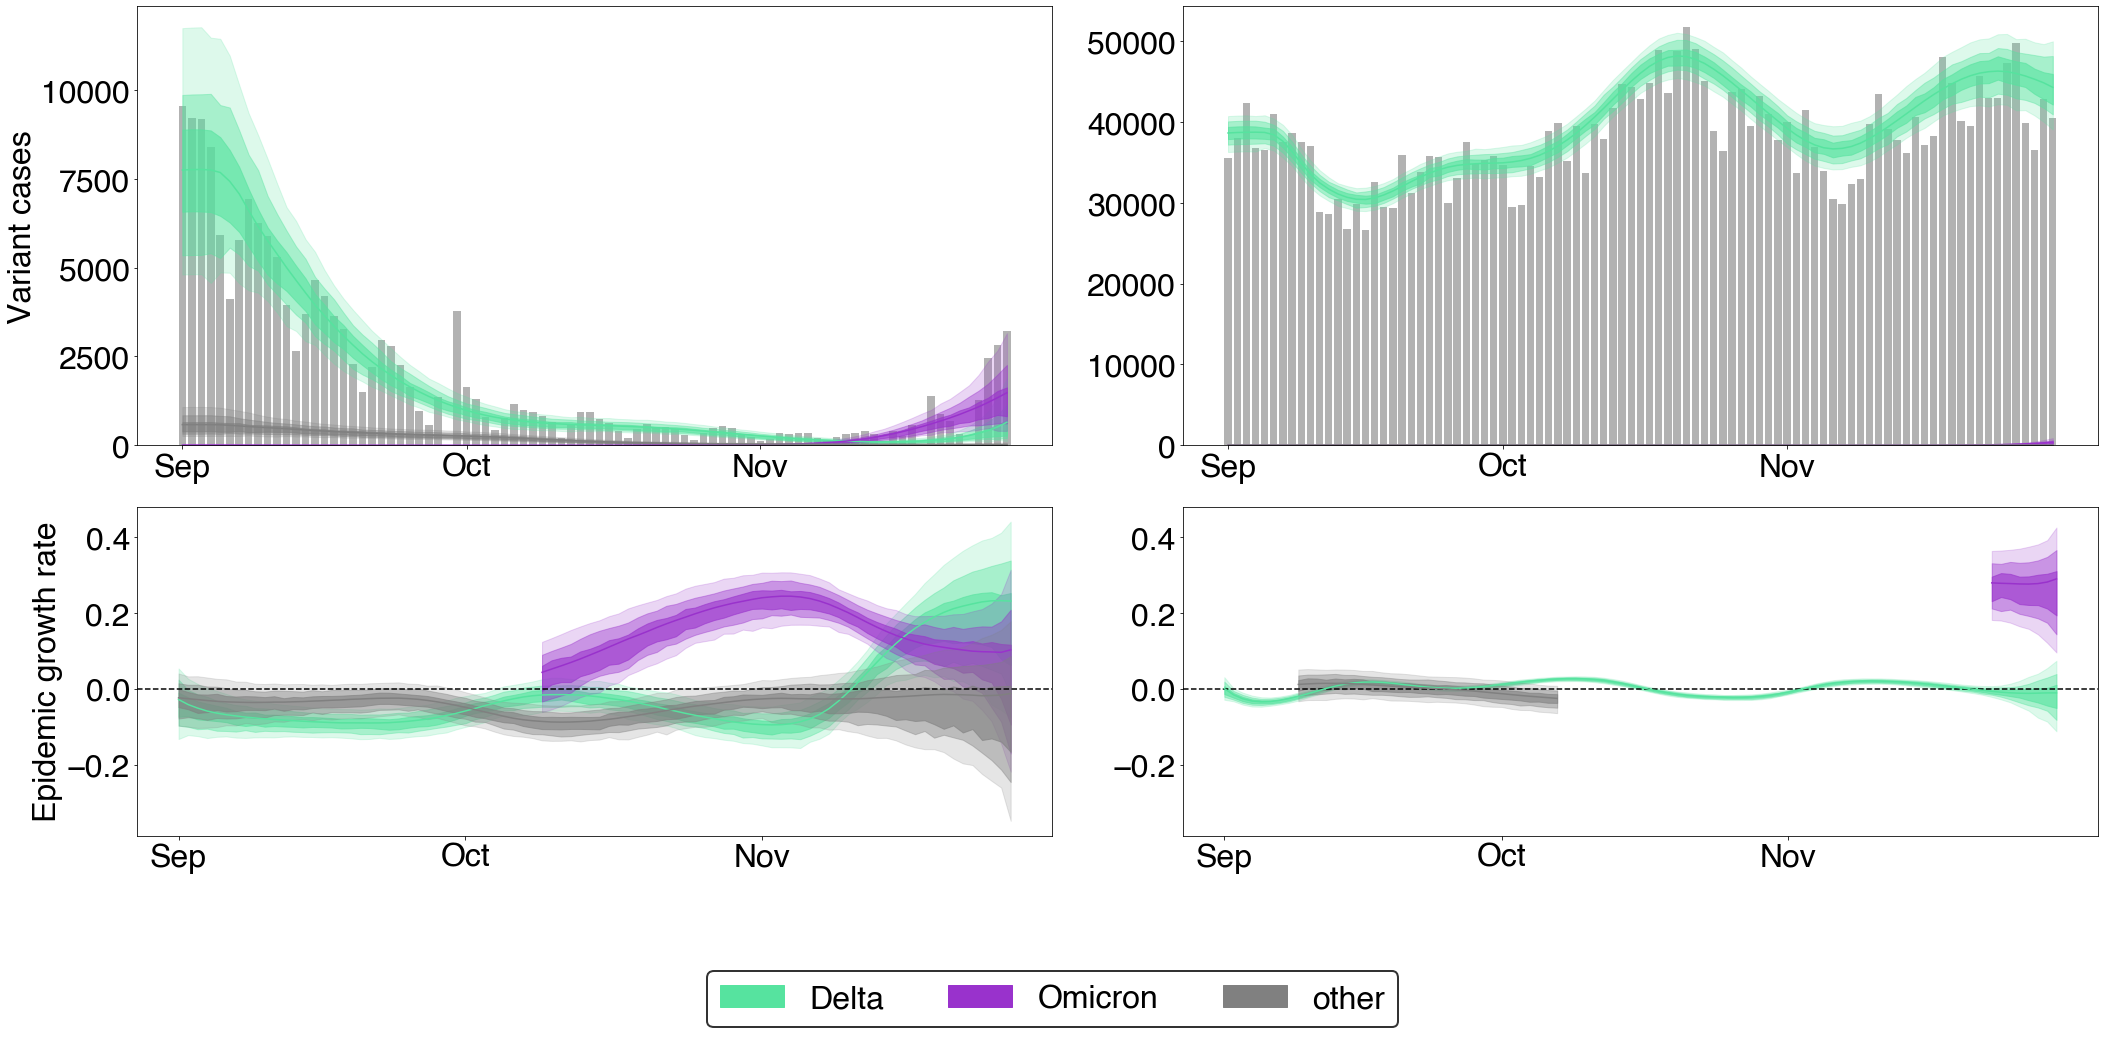

In [87]:
fig_case_r = posterior_cases_epidemic_gr_by_country(MP_free, gen, ps, alphas, color_map);

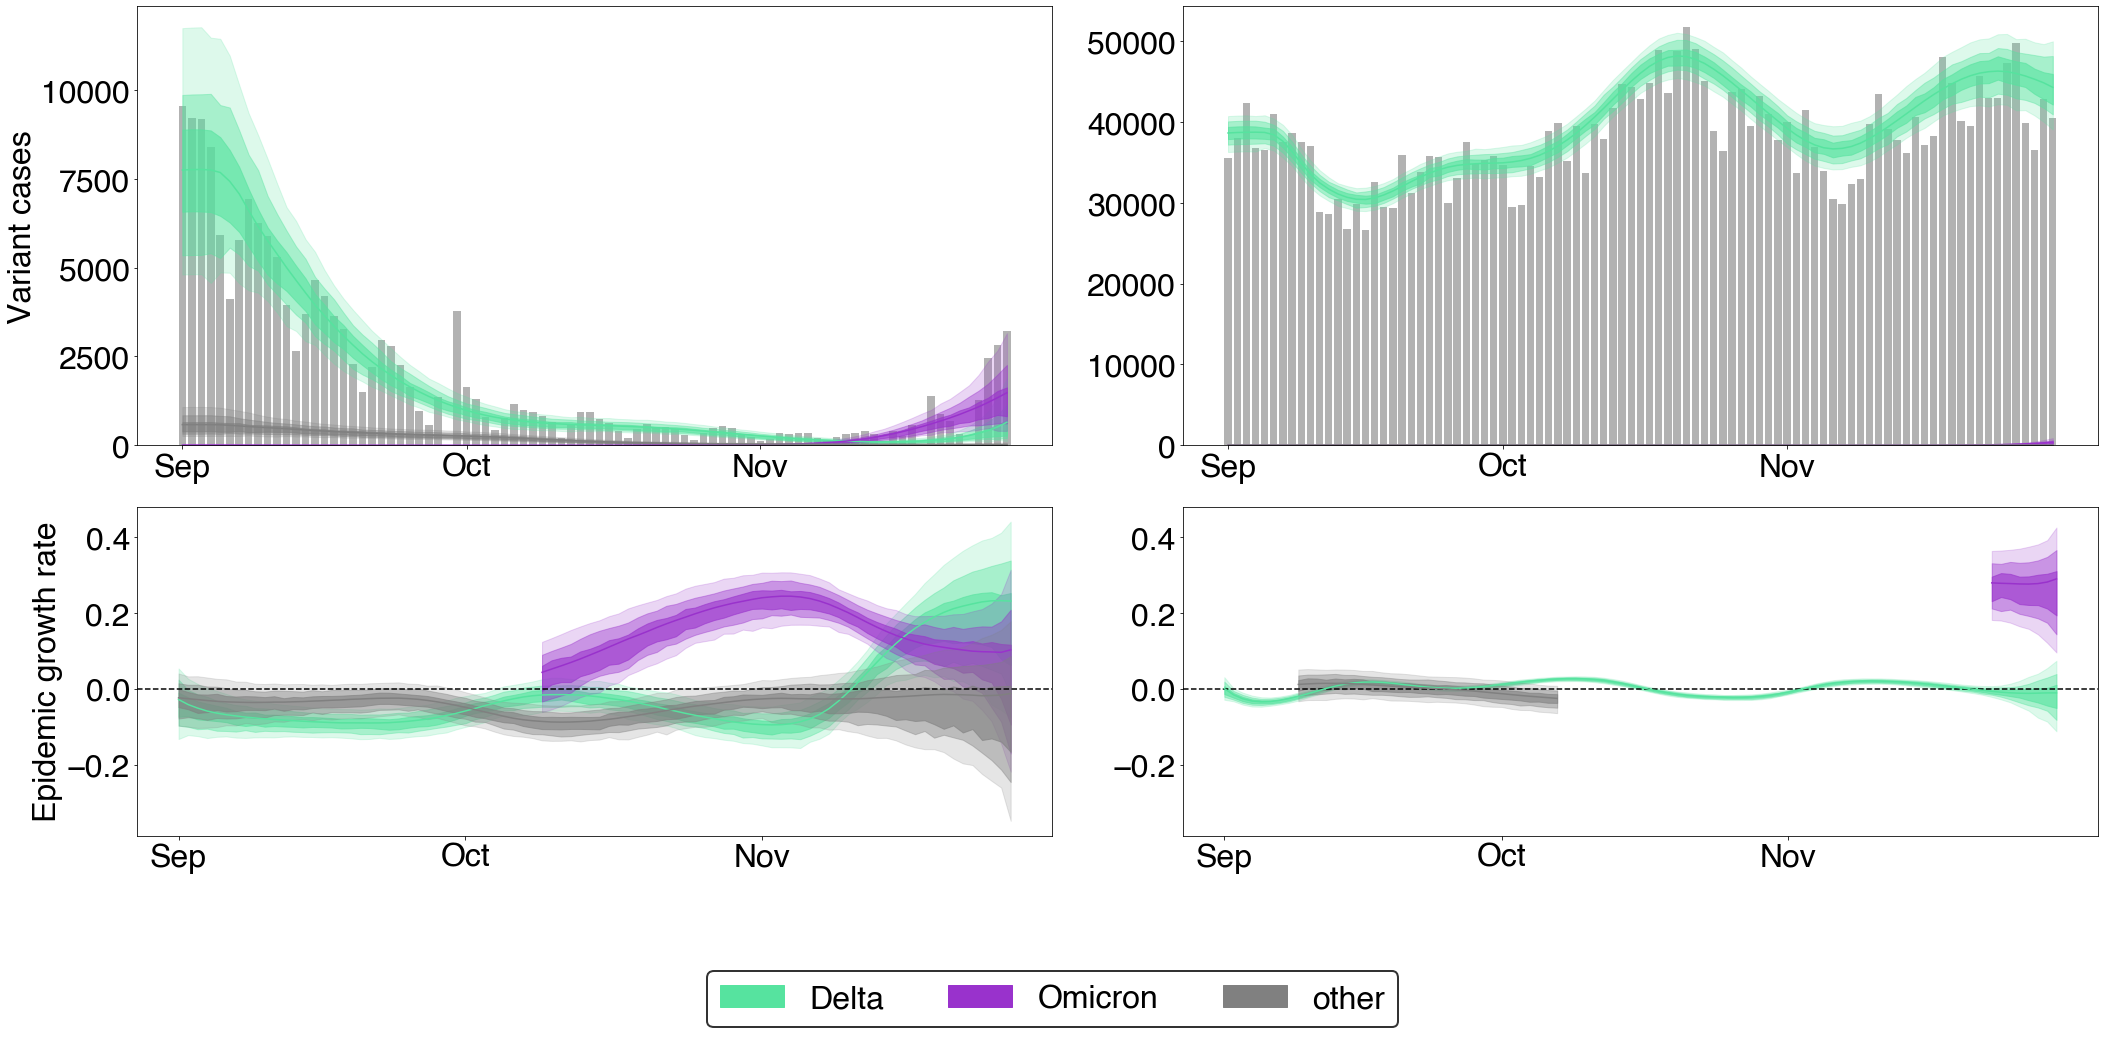

In [88]:
fig_case_r

# Saving figures


In [91]:
fig_freq.savefig(f"{path_fig}/{data_name}_frequency-estimates.png", facecolor="w", bbox_inches='tight')
fig_case_R.savefig(f"{path_fig}/{data_name}_cases-R-estimates.png", facecolor="w", bbox_inches='tight')
fig_case_r.savefig(f"{path_fig}/{data_name}_cases-little-r-estimates.png", facecolor="w", bbox_inches='tight')

# Growth advantages by variant by country

In [36]:
ga_df = pd.read_csv(f"{path_base}/{data_name}_ga-combined-fixed.tsv", sep = "\t")

In [27]:
def figure_growth_advantage(ga_df, ps, alphas, color_map):
    fig = plt.figure(figsize=(28, 20))
  
    variants = pd.unique(ga_df.variant)
    colors = [color_map[v] for v in variants]
    locations = pd.unique(ga_df.location)
    location_map = {l: i for i, l in enumerate(locations)}

    
    # Sort level of confidence  
    _lw = [1.5, 2.5, 3.5]
    
    # Top panel
    ax1 = fig.add_subplot(2,1,2)
    ax1.axhline(y=1, lw=2,linestyle='dashed', color="k")

    for v, var in enumerate(variants):
        this_lineage = ga_df[ga_df.variant == var]
        location_num = this_lineage["location"].map(location_map)
        ax1.scatter(location_num, this_lineage.median_ga.values, 
                    color=colors[v],
                    edgecolors="k",
                    s = 80,
                    zorder = 3)
        
        # Plot error bars for each level of credibility
        for i, p in enumerate(ps):
            _p = int(p * 100)
            l_err = this_lineage.median_ga.values - this_lineage[f"ga_lower_{_p}"].values
            r_err = this_lineage[f"ga_upper_{_p}"].values - this_lineage.median_ga.values 
            ax1.errorbar(location_num, this_lineage.median_ga.values, 
                         yerr=[l_err, r_err], 
                          fmt = 'none',
                         color = colors[v], elinewidth = _lw[i])
        
    
    # Adding state labels
    ax1.set_xticks(np.arange(0, len(locations), 1))
    ax1.set_xticklabels([l.replace("_", " ") for l in locations],  rotation =90)
    
    # Adding axis label
    ax1.set_ylabel("Growth Advantage")
    
    return fig

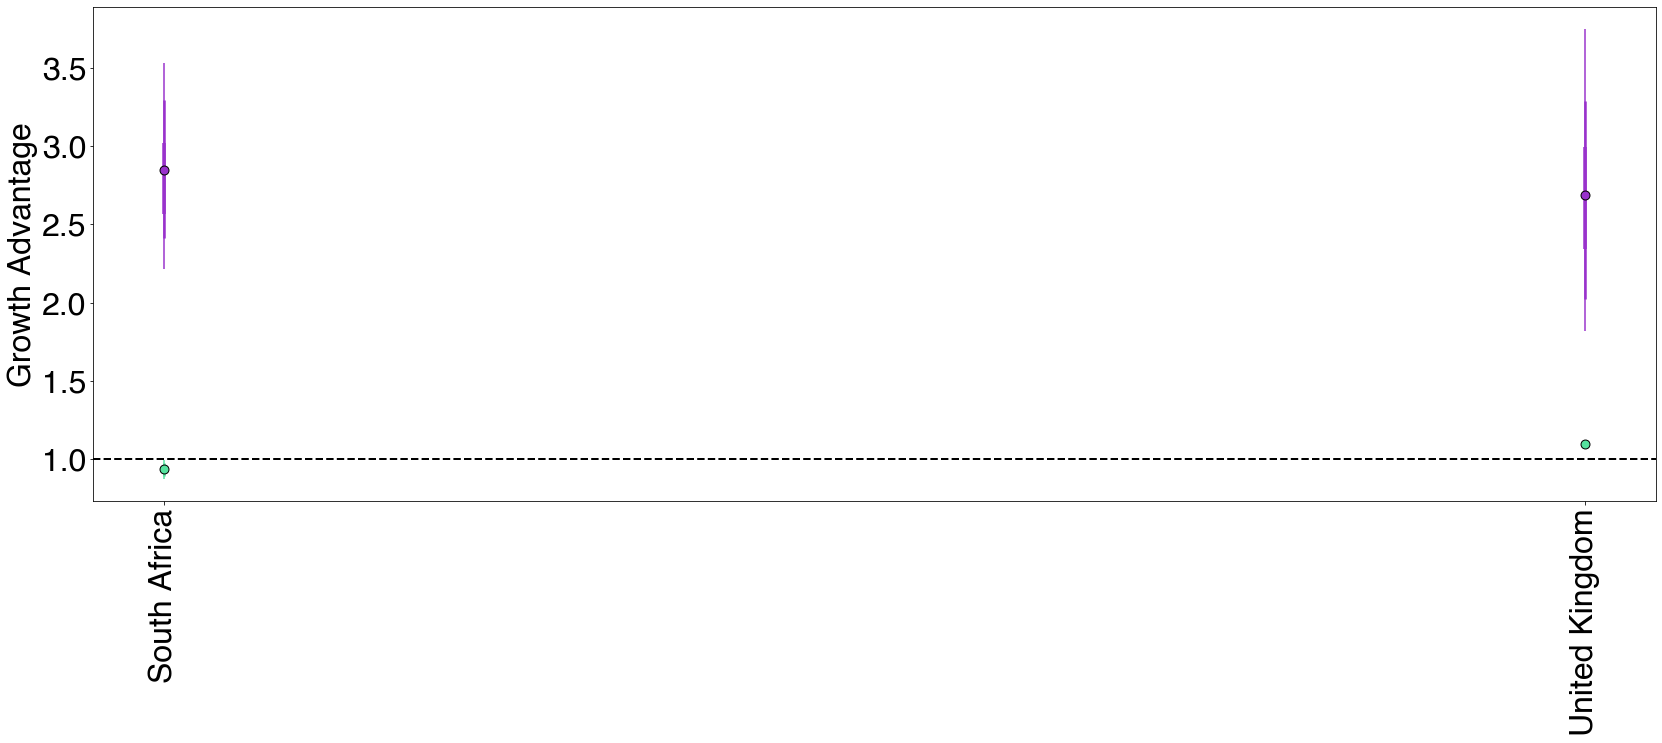

In [31]:
figure_growth_advantage(ga_df, ps, alphas, color_map);